In [1]:
import time
from DUT import DUT
import matplotlib.pyplot as plt
import numpy as np
import json
import sys

import os
import pandas as pd

In [2]:
my_dut = DUT(20, True, 3.2)

In [3]:
expected_TN_rate = 0.01

In [4]:
my_dut = DUT(20, True, 3.2)

In [5]:
print("Defected Measures:", my_dut.defected_meas) 
print("Negative Correlation:", my_dut.neg_corr)

Defected Measures: [40  2]
Negative Correlation: [(40, 37), (2, 29)]


In [6]:
n_train = 2500
n_test = 20000 - n_train * 2

In [7]:
meastime, nmeas, nport, meas, ports, expyield = my_dut.info()
print("DUT: meas. time= ", meastime, " | measurements= ", nmeas, " | ports= ", nport, " | expected yield = ", expyield)

DUT: meas. time=  128.43814099999997  | measurements=  45  | ports=  12  | expected yield =  3.2


In [8]:
error_count = 0
X = []
Y = []
t=0

data= {}
data['component']=[]

In [9]:
fails = []
my_err = 0

In [10]:
for x in range(n_train):    
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]
    
    if x % 500 == 0:
        my_dut.calibrate()
        
    toggle = True

    for i in range(0, nmeas):
        t, result, dist = my_dut.gen_meas_idx(i)
        
        if dist > 1: fails.append(i)
        
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
                
        if result == False and toggle:
            toggle = False
            my_err += 1
            break

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  0.1  took  532.1566359999999  seconds.
Calibration at  61151.27853100077  took  532.1566359999999  seconds.
Calibration at  122614.4770180065  took  532.1566359999999  seconds.
Calibration at  184496.5206400161  took  532.1566359999999  seconds.
Calibration at  245693.0115680265  took  532.1566359999999  seconds.


In [11]:
a, c = np.unique(fails, return_counts=True)
indexes = np.zeros(nmeas)
indexes[a] = c
sorted_meas = np.argsort(-indexes)

sorted_meas #= sorted_meas # [:-sum(indexes < 1)]

array([ 2, 29, 37, 40,  3,  4, 11,  6, 18,  7, 36, 14, 23, 26, 34, 10,  9,
       35, 42, 19, 20, 39, 30,  0, 41, 28, 38, 22, 25,  1, 12, 15, 17, 21,
       16, 24, 44, 27, 13,  8, 33, 32, 31, 43,  5])

In [12]:
import itertools

all_possible_tuples = {
    (i, j): 0 for i, j in itertools.product(range(nmeas), range(nmeas)) if i != j and list(sorted_meas).index(i) < list(sorted_meas).index(j) 
}

In [13]:
len(all_possible_tuples)

990

In [14]:
for x in range(n_train):    
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]
    
    if x % 500 == 0:
        my_dut.calibrate()
    
    failed = np.zeros(nmeas)

    for i in sorted_meas:
        t, result, dist = my_dut.gen_meas_idx(i)
        
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
                
        if result == False:
            failed[i] = 1
            my_err += 1
            break

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res
    
    for i, j in all_possible_tuples.keys():
        if failed[i] == 0 and failed[j] == 1:
            all_possible_tuples[(i, j)] += 1

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  307608.49596999836  took  532.1566359999999  seconds.
Calibration at  366816.16888595745  took  532.1566359999999  seconds.
Calibration at  426860.1047999164  took  532.1566359999999  seconds.
Calibration at  486130.28423687565  took  532.1566359999999  seconds.
Calibration at  545776.5726378447  took  532.1566359999999  seconds.


In [15]:
sorted_meas = []

In [16]:
for i, j in sorted(all_possible_tuples, key=all_possible_tuples.get, reverse=True):
    if i not in sorted_meas: sorted_meas.append(i)
    if j not in sorted_meas: sorted_meas.append(j)

In [17]:
for x in range(n_test):
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]
    
    if x % 500 == 0:
        my_dut.calibrate()
                
    queue_cut = 0
    exp_faults = expected_TN_rate  * ( my_err / (x + n_train) )
    for j, i in enumerate(np.flip(sorted_meas)):
        tmp = indexes[i] / float((x + n_train)) 
        if exp_faults - tmp >= 0:
            exp_faults = exp_faults - tmp
            queue_cut += 1
        else:
            break

    incount = True
    for j, i in enumerate(sorted_meas):
        t, result, dist = my_dut.gen_meas_idx(i, incount)
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
        if result == False or j >  nmeas - queue_cut:
            if result == False and incount:
                my_err +=1
            incount = False

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  606021.1914438315  took  532.1566359999999  seconds.
Calibration at  663559.2611468306  took  532.1566359999999  seconds.
Calibration at  718205.0379338418  took  532.1566359999999  seconds.
Calibration at  772301.8617408649  took  532.1566359999999  seconds.
Calibration at  826947.4471678758  took  532.1566359999999  seconds.
Calibration at  880475.5319068788  took  532.1566359999999  seconds.
Calibration at  931540.8772779008  took  532.1566359999999  seconds.
Calibration at  982364.2422449341  took  532.1566359999999  seconds.
Calibration at  1031783.3797159662  took  532.1566359999999  seconds.
Calibration at  1081969.377872112  took  532.1566359999999  seconds.
Calibration at  1131189.5239603089  took  532.1566359999999  seconds.
Calibration at  1181562.03218651  took  532.1566359999999  seconds.
Calibration at  1230954.3016027117  took  532.1566359999999  seconds.
Calibration at  1280307.2000469146  took  532.1566359999999  seconds.
Calibration at  1330057.2340291

Total:  2103525.339473446 s  15000  (  2002  |  1892  |  2002  ) ==>  0.8665333333333334
1909


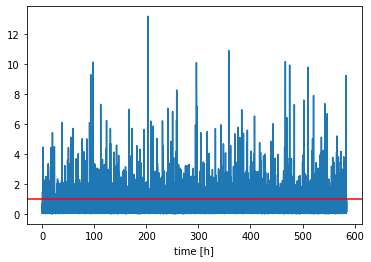

In [18]:

error_dut, error_meas = my_dut.get_errordutcount()
print("Total: ",t, "s ", x+1, " ( ", error_count, " | ", error_dut, " | ", error_meas, " ) ==> ", (x+1-error_count)/(x+1) )
print(my_err)
# write json log
# outfile = open('result.json', 'w')
# json.dump(data, outfile, indent=2)

# plot results
timeAxis = [x / 3600. for x in X]
plt.xlabel('time [h]')
plt.plot(timeAxis,Y)
plt.axhline(y=1., xmin=0, xmax=1, color='r')
plt.show()


